<a href="https://colab.research.google.com/github/jiminmini/mini/blob/main/4_28_%ED%95%84%EC%82%AC%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**[개념 정리]**

#**XGBoost 모델 학습과 하이퍼 파라미터 튜닝**


*   ROC AUC로 평가

*   HyperOpt로 하이퍼 파라미터 튜닝


---

#**언더 샘플링과 오버 샘플링의 이해**

*    get_train_test_dataset( )는 get_preprocessed_clf( )를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환


---


#**이상치 제거 후 모델 학습/예측/평가**

*   이상치 데이터: IQR을 이용해 제거

*   상관관계 히트맵

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] ==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print( 'unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

 # 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1 로 분리
X_features = cust_df.iloc[:, :-1 ]
y_labels = cust_df.iloc[:, -1 ]
print('피처 데이터 shape：{0}'.format(X_features.shape))

피처 데이터 shape：(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2,random_state=0)
train_cnt = y_train.count()
test_cnt = y_test. count()
print('학습 세트 Shape：{0}, 테스트 세트 Shape：{1}' .format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율' )
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape：(60816, 369), 테스트 세트 Shape：(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3,random_state=0)

In [ ]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import xgboost
print(xgboost.__version__)

3.0.0


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# DMatrix 변환
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# 파라미터 설정
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'eval_metric': 'auc',
    'seed': 156
}

# 모델 학습 (조기 종료 포함)
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=100,
    verbose_eval=True
)

# 예측 및 AUC 평가
y_pred_proba = xgb_model.predict(dtest)
xgb_roc_score = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))


[0]	train-auc:0.84104	eval-auc:0.81454
[1]	train-auc:0.84488	eval-auc:0.81613
[2]	train-auc:0.84812	eval-auc:0.81844
[3]	train-auc:0.85180	eval-auc:0.81988
[4]	train-auc:0.85424	eval-auc:0.82153
[5]	train-auc:0.85771	eval-auc:0.82355
[6]	train-auc:0.85919	eval-auc:0.82479
[7]	train-auc:0.86097	eval-auc:0.82580
[8]	train-auc:0.86158	eval-auc:0.82608
[9]	train-auc:0.86252	eval-auc:0.82734
[10]	train-auc:0.86337	eval-auc:0.82816
[11]	train-auc:0.86438	eval-auc:0.82862
[12]	train-auc:0.86544	eval-auc:0.82971
[13]	train-auc:0.86660	eval-auc:0.83028
[14]	train-auc:0.86727	eval-auc:0.83086
[15]	train-auc:0.86787	eval-auc:0.83148
[16]	train-auc:0.86869	eval-auc:0.83203
[17]	train-auc:0.86900	eval-auc:0.83223
[18]	train-auc:0.86953	eval-auc:0.83232
[19]	train-auc:0.87013	eval-auc:0.83247
[20]	train-auc:0.87108	eval-auc:0.83260
[21]	train-auc:0.87231	eval-auc:0.83269
[22]	train-auc:0.87315	eval-auc:0.83282
[23]	train-auc:0.87394	eval-auc:0.83296
[24]	train-auc:0.87441	eval-auc:0.83302
[25]	train

In [ ]:
from hyperopt import hp

 # max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01 에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample—bytree': hp.uniform('colsample.bytree', 0.5, 0.95),
                    'learning.rate': hp.uniform('learning_rate', 0.01, 0.2) }

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

 # fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'])

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
roc_auc_list = []

# 3개 k-fold 방식 적용
kf = KFold(n_splits=3, shuffle=True, random_state=156)

# X_train을 다시 학습과 검증용 데이터로 분리
for tr_index, val_index in kf.split(X_train):
    # 학습과 검증 데이터 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # DMatrix로 변환
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 파라미터 설정
    params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.05,
        'eval_metric': 'auc',
        'seed': 156
    }

    # XGBoost 모델 학습 (early stopping = 30)
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=30,
        verbose_eval=False
    )

    # 검증 세트에 대한 예측 및 AUC 계산
    y_pred_proba = xgb_model.predict(dval)
    score = roc_auc_score(y_val, y_pred_proba)
    roc_auc_list.append(score)

# 평균 ROC AUC 반환 (Hyperopt 목적 함수용으로 -1 곱함)
result = -1 * np.mean(roc_auc_list)


In [ ]:
import numpy as np
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK
from sklearn.metrics import accuracy_score
import xgboost as xgb
from functools import partial

# 1. 목적 함수 정의
def objective_func(params, X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    return {'loss': -accuracy, 'status': STATUS_OK}  # fmin은 loss를 최소화함

# 2. 하이퍼파라미터 탐색 공간 정의
xgb_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# 3. 데이터 준비 (예시)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. partial을 사용해 인자 고정
objective_with_data = partial(objective_func, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# 5. 하이퍼파라미터 튜닝 실행
trials = Trials()
best = fmin(
    fn=objective_with_data,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(seed=30)
)

print('best:', best)

100%|██████████| 50/50 [00:11<00:00,  4.38trial/s, best loss: -1.0]
best: {'colsample_bytree': np.float64(0.5354678394700998), 'learning_rate': np.float64(0.17338749347975219), 'max_depth': np.float64(6.0), 'n_estimators': np.float64(70.0), 'subsample': np.float64(0.6257959595266089)}


In [ ]:
import xgboost as xgb

# DMatrix 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# 파라미터 설정 (best 기반)
params = {
    'objective': 'binary:logistic',
    'learning_rate': round(best['learning_rate'], 5),
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best.get('min_child_weight', 1)),  # 기본값 사용
    'colsample_bytree': round(best['colsample_bytree'], 5),
    'eval_metric': 'auc'
}

# 학습
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=100,
    verbose_eval=False
)

# 예측 및 평가
probs = model.predict(dval)
from sklearn.metrics import roc_auc_score
xgb_roc_score = roc_auc_score(y_test, probs)
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

XGBoostError: [15:48:24] /workspace/src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7dc8182a6acc]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xef8f19) [0x7dc818ef8f19]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x68bdf2) [0x7dc81868bdf2]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x77) [0x7dc8181b6ba7]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7dc8bf337e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7dc8bf334493]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7dc8bf5984d8]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7dc8bf597c8e]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x27c) [0x52f6dc]



In [ ]:
from hyperopt import hp

xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),             # 깊이: 3~10
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),     # 학습률
    'subsample': hp.uniform('subsample', 0.6, 1.0),               # 샘플 비율
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),# 트리별 컬럼 샘플링 비율
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),# 자식 노드 최소 가중치
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),               # L1 정규화
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)              # L2 정규화
}


In [ ]:
from hyperopt import STATUS_OK

def objective_func(params):
    # params를 이용해 모델을 학습하고, 손실 값을 계산합니다.
    loss = your_model_training_function(params)
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
from hyperopt import STATUS_OK

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 모델 학습 함수 정의
def your_model_training_function(params, X_train, y_train, X_test, y_test):
    # XGBoost 모델을 하이퍼파라미터에 맞춰 학습
    model = xgb.XGBRegressor(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators']
    )

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측 및 MSE 계산
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse


In [ ]:
!pip


Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                  A helper c

NotFittedError: need to call fit or load_model beforehand

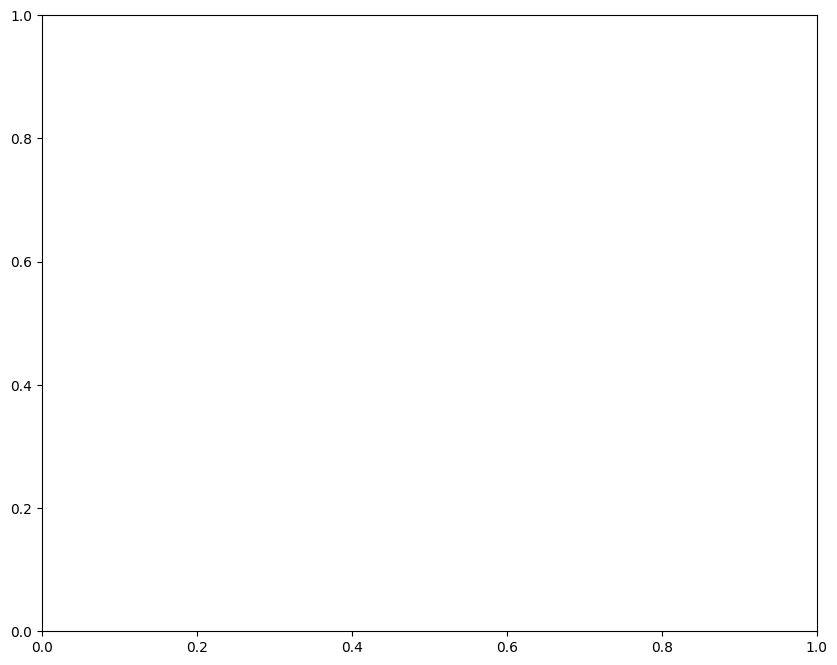

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                      'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1 ),
                     'min_child_samples' : hp.quniform('min_child_samples',
                      60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                     }

In [ ]:
def objective_func(params, X_train, y_train, X_test, y_test):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=float(params['learning_rate']),
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves'])
    )

    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)

    # 다중 클래스용 AUC
    score = -roc_auc_score(y_test, preds, multi_class='ovr', average='macro')

    return score


In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()
# fminO 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))
print('best：', best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: objective_func() missing 4 required positional arguments: 'X_train', 'y_train', 'X_test', and 'y_test'


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: objective_func() missing 4 required positional arguments: 'X_train', 'y_train', 'X_test', and 'y_test'

In [3]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(bes['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['mir_child_samples']),
                          subsample=round(best['subsample'], 5),
                          learning_rate=round(best['learning_rate'], 5)
                          )
 # evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
             eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1 ])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

NameError: name 'LGBMClassifier' is not defined

In [1]:
%pip install -U imbalanced-learn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pit
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
from sklearn.model_selection import train_test_split

 # 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df .copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [7]:
from sklearn.model_selection import train_test_split

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)

    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    # y_target에서 NaN 값이 있는 행을 제거
    df_cleaned = df_copy.dropna(subset=[df_copy.columns[-1]])  # 마지막 컬럼에 NaN 값이 있는 행 제거

    X_features_cleaned = df_cleaned.iloc[:, :-1]
    y_target_cleaned = df_cleaned.iloc[:, -1]

    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features_cleaned, y_target_cleaned,
                                                        test_size=0.3, random_state=0, stratify=y_target_cleaned)

    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)


학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred):
    # 정확도 (Accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    # 정밀도 (Precision)
    precision = precision_score(y_test, y_pred)
    # 재현율 (Recall)
    recall = recall_score(y_test, y_pred)
    # F1 점수 (F1-score)
    f1 = f1_score(y_test, y_pred)
    # ROC AUC 점수 (ROC AUC Score)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')



In [9]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

 # 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred)

Accuracy: 0.9992
Precision: 0.8667
Recall: 0.6149
F1 Score: 0.7194
ROC AUC Score: 0.8074


In [10]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None,tgt_train=None,
    tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

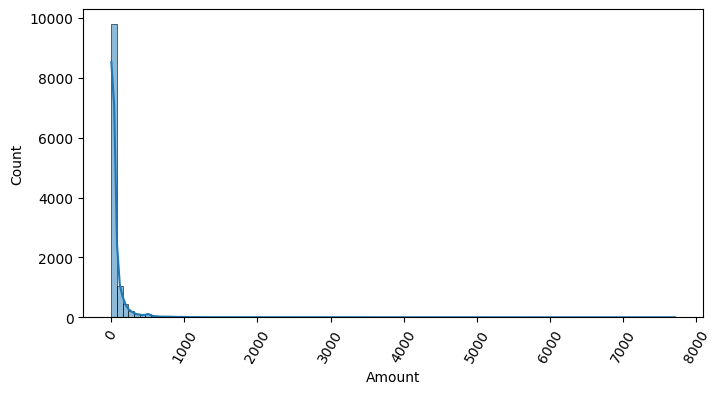

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
df=pd.read_csv('creditcard.csv')
# 예시 데이터 (df가 이미 존재한다고 가정)
# NaN 값 확인 및 제거
df_cleaned = df.dropna()

# 피처와 타겟 분리
X_features = df_cleaned.iloc[:, :-1]
y_target = df_cleaned.iloc[:, -1]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

# 모델 학습 및 예측
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
 # 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df .copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
 # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

 # Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')

lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgtxn_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df .copy()
 # 넘파이의 log1p( )를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test,
                     tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


TypeError: get_clf_eval() takes 2 positional arguments but 3 were given

<Axes: >

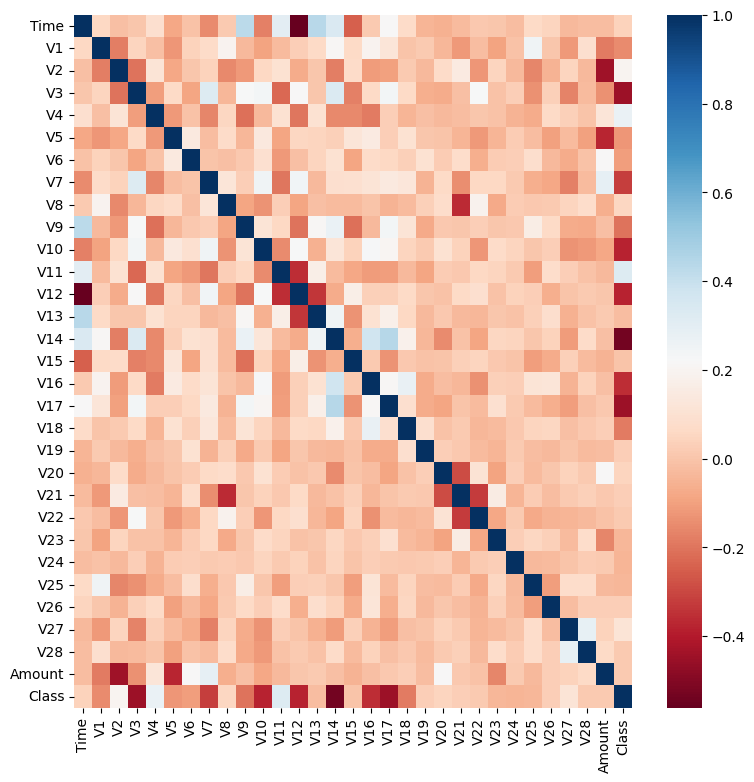

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
# fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구항.
    fraud = df[df[ 'Class' ]==1 ] [column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
# IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 -quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
 # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([], dtype='int64')


In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print ('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train. shape, y_train. shape)
print ('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (8370, 29) (8370,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (16668, 29) (16668,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0.0    8334
1.0    8334
Name: count, dtype: int64


In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
 # ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 yjxairvover로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

TypeError: get_clf_eval() takes 2 positional arguments but 3 were given

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 8334, number of negative: 8334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 16668, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

TypeError: get_clf_eval() takes 2 positional arguments but 3 were given